# Naive Bayes Bag-of-Words Classifier Implementation

In [72]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [94]:
df = pd.read_json('yelp_data/yelp_academic_dataset_review_50k.json', lines=True)
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,oUVfM9ua2UtJ68sHKgCvNA,-YzMXeOVQfWAVXNAtMSbyw,dnQMntrmickWGYLB30KBEQ,4,0,0,0,Coffee is VERY good. My breakfast was a welcom...,2014-07-16 13:01:33
1,E7QcmW1jmB6T3HkSMdLGDA,jLNR8Tsvi47ENvoNfVYKiQ,4GGhj7Z99E5IYWdEqOsLUQ,5,0,0,0,"I've been coming to this place for 18 years, a...",2019-04-16 20:17:17
2,GgGLzyl408biArY9oLGbRQ,392lRckiPvP-xTZ10E5RPw,c3QxX3toWdqJnKQmmIliRQ,2,0,0,0,This place is a bit overrated. It is very tren...,2021-05-02 23:53:15
3,B-EtTJZH45iCGWDNU36-1Q,OIa6ptM1qUts5arovQUAFQ,-QI8Qi8XWH3D8y8ethnajA,2,6,1,2,"This is an older airport, and it reminded me a...",2018-04-13 15:51:03
4,RJb-x897_abr1CZDYiB1Xw,fwOETgbWmBAhdO9058e4Zg,C5ZOzlslhMxRJDjBDV3KoQ,5,0,0,0,Awesome. One of my favorites. They have less ...,2016-03-27 18:29:16


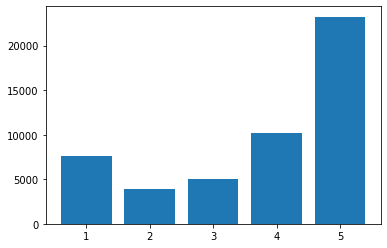

In [95]:
def plot_df_category_freq(df):
    stars = [1, 2, 3, 4, 5]
    num_reviews = []
    for star in stars:
        num_reviews.append(len(df.loc[df.stars == star]))

    from matplotlib import pyplot
    pyplot.bar(stars, num_reviews)

plot_df_category_freq(df)

In [96]:
def build_subset(df, y, classes, distributions):
    if len(classes) != len(distributions):
        raise Exception('classes and distributions must be same length')
    
    dfs = []
    for i in range(len(classes)):
        dfs.append(df.loc[df[y] == classes[i]].sample(n=distributions[i]))

    return pd.concat(dfs)


In [97]:
# different options for df_s
# df_s = build_subset(df, 'stars', [1, 2, 3, 4, 5], [3800, 3800, 3800, 3800, 3800]) # make a dataset with all 5 star ratings, pulling 3800 samples from each rating
# df_s = build_subset(df, 'stars', [1, 2, 4, 5], [3800, 3800, 3800, 3800]) # make a dataset only considering 1, 2, 4, 5 star ratings
df_s = build_subset(df, 'stars', [1, 5], [5500, 5500]) # make a dataset only considering 1 and 5 star ratings

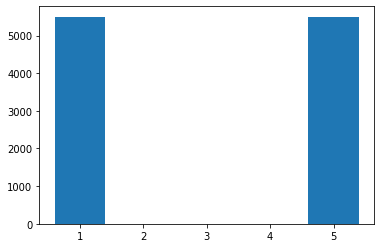

In [98]:
# now each category has same # of samples
plot_df_category_freq(df_s)

In [99]:
X = df_s[['text']]
y = df_s['stars'].replace([1, 2],0).replace([3, 4, 5], 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [79]:
# Written based on pseudocode at https://web.stanford.edu/~jurafsky/slp3/4.pdf
class NaiveBayesBoWClassifier:
    def __all_vocab(self, X_train):
        vocab = []
        for i in range(len(X_train)):
            vocab.append(X_train.iloc[i].text)

        return CountVectorizer().fit(vocab).vocabulary_
    
    def __class_vocab(self, X_train, y_train):
        df = pd.concat([X_train, y_train], axis=1)

        category_words = {}
        for i in range(len(df)):
            row = df.iloc[i]
            if row.stars not in category_words:
                category_words[row.stars] = [row.text]
            else:
                category_words[row.stars].append(row.text)

        category_vocab = {}
        for category in category_words.keys():
            category_vocab[category] = CountVectorizer().fit(
                category_words[category]).vocabulary_

        return category_vocab
    
    def __cat_vocab_count(self, cat_vocab):
        n_words_in_class = {}
        for cat in cat_vocab.keys():
            n_words_in_class[cat] = 0
            for word in cat_vocab[cat].keys():
                n_words_in_class[cat] += cat_vocab[cat][word]
        return n_words_in_class

    # alpha is for smoothing, default is Laplace (alpha=1)
    def fit(self, X_train, y_train, alpha=1):
        # bag of words for all reviews
        doc_vocab = self.__all_vocab(X_train)
        # bag of words per review category (# stars)
        cat_vocab = self.__class_vocab(X_train, y_train)
        self.categories = cat_vocab.keys()
        # for each category c contains P(c)
        log_prior = {}
        # P(w|c) for every word, class
        log_likelihood = {}
        # class: # words in class vocab
        n_words_in_cat = self.__cat_vocab_count(cat_vocab)
        for cat in cat_vocab.keys():                    # for every classification category
            # total number of documents (reviews)
            n_doc = len(X_train)
            # number of documents with category cat
            n_c = len(y_train.loc[y_train == cat])
            # log probability that a document is of this category P(c)
            log_prior[cat] = np.log(n_c/n_doc)

            for word in doc_vocab.keys():               # for every word seen across all documents
                count_w_c = 0
                if word in cat_vocab[cat]:
                    # num times word was seen in current category (cat)
                    count_w_c = cat_vocab[cat][word]
                log_likelihood[(word, cat)] =               \
                    np.log((count_w_c+alpha) /
                        (n_words_in_cat[cat]+alpha))

        self.log_prior = log_prior
        self.log_likelihood = log_likelihood
        self.vocab = doc_vocab
        
        return self

    def predict(self, X_test):
        predictions = []
        for i in range(len(X_test)):
            sample = X_test.iloc[i]
            sum = {}
            for cat in self.categories:
                sum[cat] = self.log_prior[cat]

                for word in CountVectorizer().fit([sample.text]).vocabulary_.keys():
                    if word in self.vocab:
                        sum[cat] += self.log_likelihood[(word, cat)]

            max = np.NINF
            max_cat = -1
            for cat in sum:
                if sum[cat] > max:
                    max = sum[cat]
                    max_cat = cat

            if max_cat == -1:
                raise Exception('category not found')

            predictions.append(max_cat)

        return pd.Series(predictions)
    
    def score(self, true, pred):
        if len(true) != len(pred):
            raise Exception('True and Pred arrays not same size')
        
        correct = 0
        for i in range(len(pred)):
            if pred.iloc[i] == true.iloc[i]:
                correct += 1

        return correct/len(true)


In [10]:
nb = NaiveBayesBoWClassifier().fit(X_train, y_train)
pred = nb.predict(X_test)
nb.score(y_test, pred)

0.7172727272727273

In [91]:
def preprocess_not(sample):
    if ("n\'t" not in sample) and ("not" not in sample):
        return sample
    
    tokens = sample.split()
    s = ''
    i = 0
    while i < len(tokens):
        token = tokens[i]
        if 'not' == token or 'n\'t' in token:
            s += f'{tokens[i]} '
            for w in range(i+1, len(tokens)):
                s += f'NOT_{tokens[w]} '
                if '.' in tokens[w]:
                    break
                i += 1
            i += 1
        else:
            s += f'{tokens[i]} '

        i+=1

    return s


In [100]:
for i in range(len(X)):
    X.iloc[i].text = preprocess_not(X.iloc[i].text)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [102]:
nb = NaiveBayesBoWClassifier().fit(X_train, y_train)

pred = nb.predict(X_test)

nb.score(y_test, pred)

0.7109090909090909

In [71]:
preprocess_not('The pizza was gross. It was not hot or tasty. It wasn\'t yummy at all. So bad')

"The pizza was gross. It was not NOT_hot NOT_or NOT_tasty. It wasn't NOT_yummy NOT_at NOT_all. So bad "